In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, resample, periodogram
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Read data

In [3]:
PATH_DATA="DATA/IN.txt"
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65250 entries, 0 to 65249
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65250 non-null  int64 
 1   event    65250 non-null  int64 
 2   device   65250 non-null  object
 3   channel  65250 non-null  object
 4   code     65250 non-null  int64 
 5   size     65250 non-null  int64 
 6   data     65250 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB
None


,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [4]:
N_CHANNELS = df.channel.nunique()

In [5]:
df.data=df.data.progress_apply(lambda x: [float(i) for i in x.split(",")])

In [6]:
# Resample

def get_values_df(df_aux,resample_value=256):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(5,-1)
    channels_values=resample(channels_values,resample_value,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe

df_preprocessed=df.groupby(['event']).progress_apply(lambda row: get_values_df(row)).reset_index()

In [7]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_test].reset_index(drop=True)

In [8]:
N_CHANNELS

5

In [9]:
df_train.iloc[0].eeg.shape

(5, 256)

In [10]:
df_train.eeg.values.shape

(10440,)

In [11]:
# Standarization
NORM_BY = "channel" # "all"

if NORM_BY=="channel":
    scalers=dict(zip(list(range(N_CHANNELS)),[StandardScaler() for x in range(N_CHANNELS)]))

    # Fitting the scalers
    for i in range(N_CHANNELS):
        scalers[i].fit(np.asarray([x[i] for x in df_train.eeg.values]))

    # Standarization of the data
    for i in tqdm(range(N_CHANNELS)): 
        df_train[f"channel_{i}"]=list(scalers[i].transform([x[i] for x in df_train.eeg.values]))
    
    for i in tqdm(range(N_CHANNELS)):
        df_test[f"channel_{i}"]=list(scalers[i].transform([x[i] for x in df_test.eeg.values]))

df_train.head()

,event,eeg,label,channel_0,channel_1,channel_2,channel_3,channel_4
0,180187,"[[4277.948716999999, 4283.076923000001, 4276.9...",4,"[-0.4089923219851625, -0.2862057300676179, -0....","[0.04114473344744017, -0.154329455598954, -0.2...","[0.3062747623582641, 0.4378076810266323, 0.419...","[0.1863917340224224, 0.33277562394364063, 0.15...","[0.4088384260938193, -0.13996454068586714, -0...."
1,180942,"[[4230.256410000001, 4240.682899890823, 4231.6...",3,"[-1.4405427928577532, -1.165159712780104, -1.4...","[-1.2044239480725039, -1.000296413978728, -1.2...","[-0.9082877774632108, -0.6358048233905929, -0....","[-0.5750865363188178, -0.37494135682037233, -0...","[-1.2428119006569365, -0.34545070323173344, -0..."
2,184457,"[[4278.461537999998, 4282.051281999999, 4283.0...",6,"[-0.39790037073982304, -0.30747031350815013, -...","[0.38284941789049387, 0.4404137074988624, 0.53...","[0.41008352385031177, 0.5827052362976647, 0.79...","[-0.29392531861612536, -0.07019730055196173, 0...","[0.4570617922686661, 0.4088024529963619, 0.318..."
3,183185,"[[4408.7179479999995, 4412.344190443196, 4386....",8,"[2.419452563553741, 2.393888566738031, 1.96582...","[0.0631901962665517, -0.1085569932780141, -0.3...","[-0.3788630837322571, -0.4864173287364819, -0....","[-0.047909261692952024, -0.19839511426369227, ...","[-1.2789794370425693, -1.3291952455374634, -1...."
4,180542,"[[4316.923076, 4316.410256, 4302.564102000001,...",2,"[0.43399517237969326, 0.40489324211479016, 0.1...","[0.08523565908562414, 0.34128983982363786, 0.1...","[0.731890694597115, 0.7276027713866248, 0.5752...","[-0.2587801806810031, 0.0193522382248035, 0.31...","[-0.04928355256691504, 0.575818494551834, 0.91..."


In [12]:
# Filtering

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

df_train_filtered=df_train.copy()
df_test_filtered=df_test.copy()

fs = 256/2

for i in tqdm(range(N_CHANNELS)): 
    df_train_filtered[f"channel_{i}"]=df_train_filtered[f"channel_{i}"].progress_apply(butter_bandpass_filter, args=(2,40,fs,10,))

for i in tqdm(range(N_CHANNELS)): 
    df_test_filtered[f"channel_{i}"]=df_test_filtered[f"channel_{i}"].progress_apply(butter_bandpass_filter, args=(2,40,fs,10,))

<AxesSubplot:>

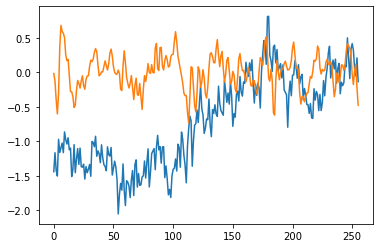

In [13]:
sns.lineplot(x=list(range(len(df_train.iloc[1].channel_0))),y=df_train.iloc[1].channel_0)
sns.lineplot(x=list(range(len(df_train_filtered.iloc[1].channel_0))),y=df_train_filtered.iloc[1].channel_0)

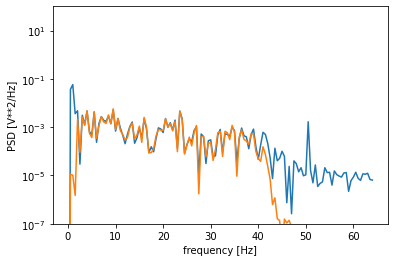

In [14]:
f, Pxx_den = periodogram(df_train.iloc[0].channel_0,fs)
plt.semilogy(f, Pxx_den)
f, Pxx_den = periodogram(df_train_filtered.iloc[0].channel_0,fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

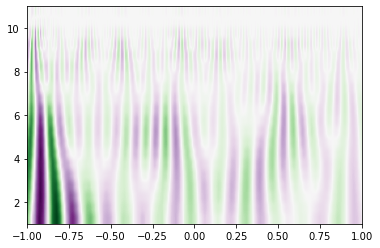

In [102]:
import pywt

t = list(np.arange(0,2,1/256))
sig  = df_train_filtered.iloc[3].channel_0
widths = np.arange(1, 21)
cwtmatr, freqs = pywt.cwt(sig, widths, 'morl')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 11], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [17]:
del df_train, df_test, df

In [103]:
def get_cwt(sig,max_width,wavelet="morl"):
    widths = np.arange(1, max_width+1)
    cwtmatr, freqs = pywt.cwt(sig, widths, wavelet)
    return cwtmatr

In [104]:
WAVELET_MAX_WIDTH=20
for i in tqdm(range(N_CHANNELS)): 
    df_train_filtered[f"wav_channel_{i}"]=df_train_filtered[f"channel_{i}"].progress_apply(get_cwt, args=(WAVELET_MAX_WIDTH,))

for i in tqdm(range(N_CHANNELS)): 
    df_test_filtered[f"wav_channel_{i}"]=df_test_filtered[f"channel_{i}"].progress_apply(get_cwt, args=(WAVELET_MAX_WIDTH,))

In [105]:
from torch.utils.data import Dataset, DataLoader
import torch

class BrainMNISTDataset(Dataset):
    """Brain MNIST dataset."""

    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame with data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.eeg_frame = df

    def __len__(self):
        return len(self.eeg_frame)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(np.stack(self.eeg_frame.loc[idx][[f"wav_channel_{i}" for i in range(N_CHANNELS)]].values),
                              dtype=torch.float),
            "y":torch.tensor(self.eeg_frame.loc[idx].label,dtype=torch.long)#torch.tensor(np.eye(10)[self.eeg_frame.loc[idx].label],dtype=torch.long),
        }

In [106]:
eeg_dataset = BrainMNISTDataset(df=df_train_filtered)

for i in range(len(eeg_dataset)):
    sample = eeg_dataset[i]
    print(sample["x"].shape)
    if i>3: break

torch.Size([5, 20, 256])
torch.Size([5, 20, 256])
torch.Size([5, 20, 256])
torch.Size([5, 20, 256])
torch.Size([5, 20, 256])


In [107]:
## Train and test dataloaders
trainloader = DataLoader(BrainMNISTDataset(df=df_train_filtered), batch_size=32, shuffle=True, num_workers=0)
evalloader = DataLoader(BrainMNISTDataset(df=df_test_filtered), batch_size=32, shuffle=False, num_workers=0)

In [108]:
for i_batch, sample_batched in enumerate(trainloader):
    print(i_batch, sample_batched["x"].size(), sample_batched["y"].size())
    if i_batch > 10: break

0 torch.Size([32, 5, 20, 256]) torch.Size([32])
1 torch.Size([32, 5, 20, 256]) torch.Size([32])
2 torch.Size([32, 5, 20, 256]) torch.Size([32])
3 torch.Size([32, 5, 20, 256]) torch.Size([32])
4 torch.Size([32, 5, 20, 256]) torch.Size([32])
5 torch.Size([32, 5, 20, 256]) torch.Size([32])
6 torch.Size([32, 5, 20, 256]) torch.Size([32])
7 torch.Size([32, 5, 20, 256]) torch.Size([32])
8 torch.Size([32, 5, 20, 256]) torch.Size([32])
9 torch.Size([32, 5, 20, 256]) torch.Size([32])
10 torch.Size([32, 5, 20, 256]) torch.Size([32])
11 torch.Size([32, 5, 20, 256]) torch.Size([32])


In [109]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


class Net(pl.LightningModule):
    def __init__(self, n_classes=10, debug=False):
        super(Net, self).__init__()
        self.debug=debug
        self.n_classes=n_classes
        self.n_channels=N_CHANNELS
        self.wavelet_max_width=WAVELET_MAX_WIDTH
        self.seq_length=SEQ_LENGTH

        self.conv1 = nn.Conv2d(self.n_channels, 32, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.fc1 = nn.Linear(64*int((int((self.seq_length-2+1)/2)-2+1)/2)*int((int((self.wavelet_max_width-2+1)/2)-2+1)/2), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, self.n_classes)

        self.accuracy = pl.metrics.Accuracy()


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.debug: print("conv1 -> relu -> pool: ",x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        if self.debug: print("conv2 -> relu -> pool: ",x.shape)
        x = x.view(-1, 64*int((int((self.seq_length-2+1)/2)-2+1)/2)*int((int((self.wavelet_max_width-2+1)/2)-2+1)/2))
        if self.debug: print("flatten ",x.shape)
        x = F.relu(self.fc1(x))
        if self.debug: print("fc1 -> relu: ",x.shape)
        x = F.relu(self.fc2(x))
        if self.debug: print("fc2 -> relu: ",x.shape)
        x = self.fc3(x)
        if self.debug: print("out: ",x.shape)
        return x

    def loss_fn(self,out,target):
        return nn.CrossEntropyLoss()(out.view(-1,self.n_classes),target)
    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer

    def training_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,self.n_channels,self.wavelet_max_width,self.seq_length)
        label = y.view(-1)
        #print(label)
        out = self(img)
        loss = self.loss_fn(out,label)
        self.log('train_loss', loss)
        return loss

    def validation_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,self.n_channels,self.wavelet_max_width,self.seq_length)
        label = y.view(-1)
        out = self(img)
        loss = self.loss_fn(out,label)
        out = nn.Softmax(-1)(out) 
        logits = torch.argmax(out,dim=1)
        accu = self.accuracy(logits, label)        
        self.log('valid_loss', loss)
        self.log('train_acc_step', accu)
        return loss, accu


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_loss',
    dirpath='./model/',
    filename='models-{epoch:02d}-{valid_loss:.2f}',
    save_top_k=3,
    mode='min') 

class BrainMNISTLightDataset(pl.LightningDataModule):
    def __init__(self, df_train, df_val, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.df_train = df_train
        self.df_val = df_val
    
    def setup(self, stage=None):
        self.train_dataset = BrainMNISTDataset(df=self.df_train)
        self.validation_dataset = BrainMNISTDataset(df=self.df_val)

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset,
                            batch_size=self.batch_size,
                            shuffle=True)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(self.validation_dataset,
                            batch_size=self.batch_size,
                            shuffle=False)       
        return valid_loader


In [110]:
SEQ_LENGTH=256

mod = Net()
dx = BrainMNISTLightDataset(df_train_filtered, df_test_filtered)
trainer = pl.Trainer(max_epochs=6,callbacks=[checkpoint_callback],num_sanity_val_steps=0)
trainer.fit(model=mod,datamodule=dx) 

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 672   
1 | pool     | MaxPool2d | 0     
2 | conv2    | Conv2d    | 8.3 K 
3 | fc1      | Linear    | 516 K 
4 | fc2      | Linear    | 528   
5 | fc3      | Linear    | 170   
6 | accuracy | Accuracy  | 0     
---------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params


1

In [69]:
trainer.test(test_dataloaders=evalloader)

1

In [111]:
model = Net.load_from_checkpoint("model/models-epoch=03-valid_loss=2.30.ckpt")

predictions=[]
gt=[]

evalloader = DataLoader(BrainMNISTDataset(df=df_test_filtered), batch_size=1, shuffle=False, num_workers=0)

for i_batch, sample_batched in tqdm(enumerate(evalloader)):
    #print(i_batch, sample_batched["x"].size(), sample_batched["y"].size())
    predictions.append(np.argmax(nn.functional.softmax(model(sample_batched["x"])).detach().numpy()))
    gt.append(sample_batched["y"].detach().numpy()[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [112]:
from sklearn.metrics import classification_report

print(classification_report(gt, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       270
           1       0.00      0.00      0.00       260
           2       0.30      0.01      0.02       267
           3       0.00      0.00      0.00       271
           4       0.09      0.08      0.08       256
           5       0.15      0.02      0.03       261
           6       0.00      0.00      0.00       267
           7       0.25      0.00      0.01       238
           8       0.10      0.77      0.17       260
           9       0.12      0.11      0.12       260

    accuracy                           0.10      2610
   macro avg       0.10      0.10      0.04      2610
weighted avg       0.10      0.10      0.04      2610

